<a href="https://colab.research.google.com/github/wangjalen7/project_voting/blob/main/Project_Voting_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jalen's Model

## Data Cleaning and Visualization

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Load datasets
voting_va = pd.read_csv('./data/voting_VA.csv')
dem_primary = pd.read_csv('./data/2024 March Democratic Primary Election Results.csv')
rep_primary = pd.read_csv('./data/2024 March Republican Primary Election Results.csv')


In [19]:
# Dropping irrelevant columns
voting_data_clean = voting_data.drop(columns=['Unnamed: 0', 'state', 'state_po', 'office', 'version', 'mode'])

# Check for missing values
missing_values = voting_data_clean.isnull().sum()

# Calculating net vote counts per county per election year
# Filter to keep only Republican and Democrat votes for simplicity in calculating net vote count
voting_data_filtered = voting_data_clean[voting_data_clean['party'].isin(['REPUBLICAN', 'DEMOCRAT'])]

# Pivot table to reshape the data
pivot_data = voting_data_filtered.pivot_table(index=['year', 'county_name', 'county_fips', 'totalvotes'],
                                              columns='party', values='candidatevotes', aggfunc='sum').reset_index()

# Calculate net vote count (Republican - Democrat)
pivot_data['net_vote_count'] = pivot_data['REPUBLICAN'] - pivot_data['DEMOCRAT']

pivot_data.head(), missing_values


(party  year county_name  county_fips  totalvotes  DEMOCRAT  REPUBLICAN  \
 0      2000    ACCOMACK        51001       11925      5092        6352   
 1      2000   ALBEMARLE        51003       36846     16255       18291   
 2      2000  ALEXANDRIA        51510       55199     33633       19043   
 3      2000   ALLEGHANY        51005        5123      2214        2808   
 4      2000      AMELIA        51007        4788      1754        2947   
 
 party  net_vote_count  
 0                1260  
 1                2036  
 2              -14590  
 3                 594  
 4                1193  ,
 year              0
 county_name       0
 county_fips       0
 candidate         0
 party             0
 candidatevotes    0
 totalvotes        0
 dtype: int64)

In [29]:
# Standardize column names
dem_primary.rename(columns={'LocalityName': 'county_name', 'TOTAL_VOTES': 'total_votes'}, inplace=True)
rep_primary.rename(columns={'LocalityName': 'county_name', 'TOTAL_VOTES': 'total_votes'}, inplace=True)

# Combine the primary results into one dataset
combined_primary = pd.concat([dem_primary, rep_primary])

# Aggregate votes by county and party for the primary data
combined_primary_agg = combined_primary.groupby(['county_name', 'Party'])['total_votes'].sum().unstack().reset_index()
combined_primary_agg.fillna(0, inplace=True)  # Fill missing values with zero
combined_primary_agg['net_votes'] = combined_primary_agg['Republican'] - combined_primary_agg['Democratic']
combined_primary_agg['year'] = 2024  # Add the election year


In [37]:
# Aggregate votes by county and year
voting_va['net_votes'] = np.where(voting_va['party'] == 'REPUBLICAN', voting_va['candidatevotes'], -voting_va['candidatevotes'])
voting_va_agg = voting_va.groupby(['year', 'county_name']).agg({'net_votes': 'sum'}).reset_index()

# Apply the inverse hyperbolic sine transformation to net votes
voting_va_agg['net_votes_ihs'] = np.arcsinh(voting_va_agg['net_votes'])

# Encoding 'county_name' with OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_counties = encoder.fit_transform(voting_va_agg[['county_name']])
X = pd.DataFrame(encoded_counties, columns=encoder.get_feature_names_out(['county_name']))
X['year'] = voting_va_agg['year']

# Prepare the target variable
y = voting_va_agg['net_votes_ihs']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<ipython-input-46-8c9bc4d523d8>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=net_votes_over_time, x='year', y='net_votes', estimator='sum', ci=None)


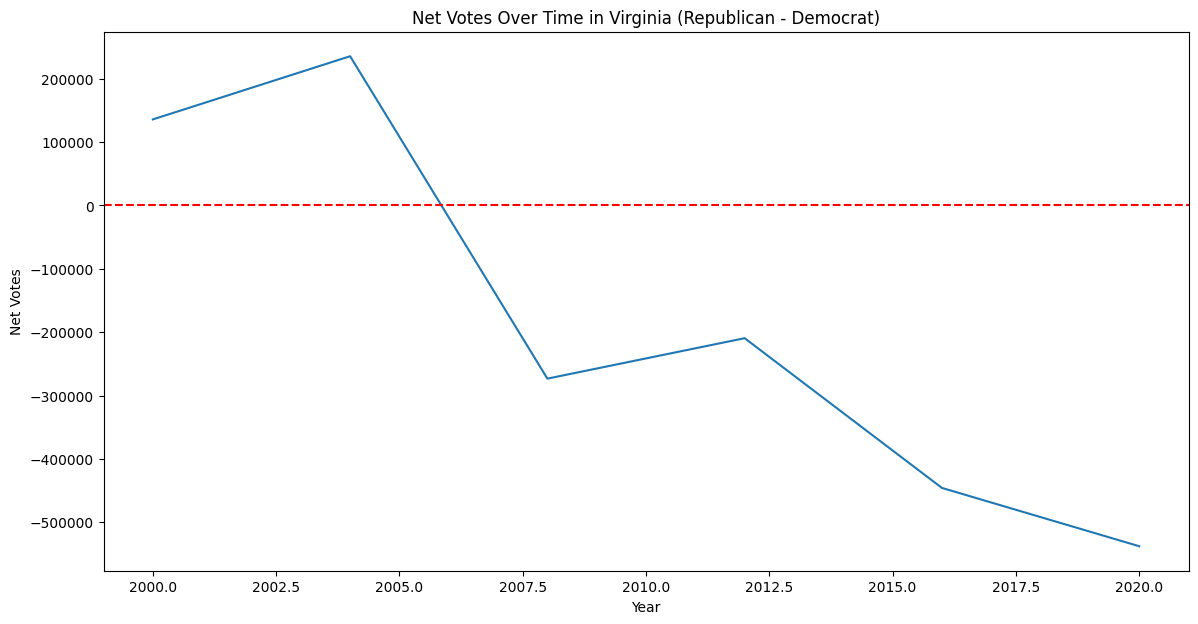

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate net votes
voting_va['net_votes'] = voting_va.apply(lambda x: x['candidatevotes'] if x['party'] == 'REPUBLICAN' else -x['candidatevotes'], axis=1)
net_votes_over_time = voting_va.groupby(['year', 'county_name'])['net_votes'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=net_votes_over_time, x='year', y='net_votes', estimator='sum', ci=None)
plt.title('Net Votes Over Time in Virginia (Republican - Democrat)')
plt.xlabel('Year')
plt.ylabel('Net Votes')
plt.axhline(0, color='red', linestyle='--')  # Zero line for reference
plt.show()




## Random Forest Regression Model

In [38]:
# Split the data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model using R^2 score
r2_score = model.score(X_test, y_test)
print(f"R^2 score for the model: {r2_score}")


R^2 score for the model: 0.5462298502822722


In [40]:
# Prepare the 2024 data
X_2024 = pd.DataFrame(encoder.transform(combined_primary_agg[['county_name']]), columns=encoder.get_feature_names_out(['county_name']))
X_2024['year'] = 2024

# Predict using the model and transform predictions
predictions_2024_ihs = model.predict(X_2024)
predictions_2024 = np.sinh(predictions_2024_ihs)

# Sum the predictions to get the overall net vote counts
total_prediction_2024 = predictions_2024.sum()
print(f"Total Net Vote Prediction for 2024: {total_prediction_2024}")


Total Net Vote Prediction for 2024: 554996.9510196939
